# Imports

In [62]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import Quantity, Unit
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

from openmm.unit import molar, kilogram, picoseconds
from dataclasses import dataclass

import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json
from pathlib import Path


# Constants & variables defined from simulation setup

In [3]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

molalities = ['1m', '2m', '3m']

knm = 4184 * kilojoule_per_mole / nanometer**2 # force constant specific to flat-bottom potential method
k=knm.in_units_of(kilojoule_per_mole/angstrom**2) # notebook works with armstrongs, so change unit of k

In [4]:
@dataclass
class Wall:
    '''For representing info about the location and orientation of a wall'''
    wall_pos : Quantity
    wall_normal : Quantity

@dataclass
class IonMolalInfo:
    '''For representing info about the systems' molecular composition'''
    molality : Quantity
    n_parts : int
    osm_coeff_exp : float
    molarity : Quantity = None

from typing import TypeAlias, TypeVar
Shape : TypeAlias = tuple
N = TypeVar('N')
M = TypeVar('M')

In [5]:
# define wall positions and ion conc parameters. This can be changed according to simulation set up.
walls = [
    Wall(
        wall_pos   =np.array([0.0, 0.0, 48.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, -1.0]) * angstrom,
    ),
    Wall(
        wall_pos   =np.array([0.0, 0.0, 96.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, 1.0]) * angstrom,
    ),
]

molal_infos = {
    1 : IonMolalInfo(
        molality=1.0*(mole / kilogram),
        n_parts=65,
        osm_coeff_exp=0.936,
        molarity=0.97597511*molar
    ),
    2 : IonMolalInfo(
        molality=2.0*(mole / kilogram),
        n_parts=128,
        osm_coeff_exp=0.984,
        molarity=1.92192022*molar
    ),
    3 : IonMolalInfo(
        molality=3.0*(mole / kilogram),
        n_parts=188,
        osm_coeff_exp=1.045,
        molarity=2.82282032*molar
    ),
}


# Utility functions

In [6]:
def osmotic_values(
        mean_force_wall : Quantity, 
        molarity : Quantity,
        cross_sectional_area : Quantity, 
        vant_hoff : int=2,
        T : Quantity=300*kelvin, 
        printvals : bool=False
    ) -> Quantity:
    '''Compute osmotic pressure and coefficient from mean force from wall'''
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_coeff=osm_bar/osm_press_ideal
    
    if printvals:
        print(f"Osmotic Pressure Observed:", osm_bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        print(f"Osmotic Coefficient:", osm_coeff)

    return osm_bar, osm_coeff

In [7]:
def filter_coords_by_wall(
    coords_rel_wall : np.ndarray[Shape[N, M, 3], float], 
    wall_normal : np.ndarray[Shape[3], float],
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[N, M, 3], float]:
    '''Zeros out all coordinates which are not in the normal direction relative to a wall'''
    in_right_direction = np.dot(coords_rel_wall, wall_normal) > 0.0
    return np.where(in_right_direction[..., np.newaxis], coords_rel_wall, 0.0) * dist_unit # need to broadcast direction bools, since dot product reduces dimension along xyz

In [8]:
def calculate_force_matrix_all_ions_rel_wall(
    coords : np.ndarray[Shape[N, M, 3], float], 
    wall_pos : np.ndarray[Shape[3], float],
    wall_normal : np.ndarray[Shape[3], float],
    K : Quantity,
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[M], float]:
    '''Calculates net harmonic force experience by particle on one side of a wall
    coords should be a 3D array with axes of time, ion index, and spatial coordinate, respectively
    wall_pos is a vector describing the position of the wall in space
    wall_normal gives the normal direction relative to the wall (to determine whether particles behnd or ahead of the wall are kept)'''
    coords_rel_wall = coords - wall_pos
    coords_behind_wall = filter_coords_by_wall(coords_rel_wall, wall_normal=wall_normal, dist_unit=dist_unit)
    z_coords_rel_wall = coords_behind_wall[..., 2]

    # NOTE: cannot use np.abs, as this will discard unit info
    return K * abs(z_coords_rel_wall) # sum along time dimension to leave array with 1 force per particle


In [9]:
def get_universe_area_and_volume(u : mda.Universe) -> tuple[Quantity, Quantity]:
    '''Returns the XY-plane area and box volume of an MDAnalysis universe'''
    box_sizes = u.dimensions[:3] * angstrom
    box_x, box_y, box_z = box_sizes

    A_box = box_x * box_y
    V_box = A_box * box_z

    return A_box, V_box

In [10]:
def replicate_analysis(results, input_name):
    """
    Calculate the mean and uncertainty (standard error) over replicate results 
    for each molal value.
    """
    # Extract values and uncertainties from the results
    op_vals = np.array([r['os_press_mean'].value_in_unit(r['os_press_mean'].unit) for r in results])
    oc_vals = np.array([r['os_coeff_mean'] for r in results])

    # Calculate standard deviations
    std_op = op_vals.std(ddof=1)
    std_oc = oc_vals.std(ddof=1)

    # Calculate means and uncertainties (standard errors)
    mean_op = op_vals.mean()
    op_uncertainty = std_op / np.sqrt(len(op_vals))
    mean_oc = oc_vals.mean()
    oc_uncertainty = std_oc / np.sqrt(len(oc_vals))

    # Display results
    print(f"----- Results standard deviation over replicates for {input_name} molal -----")
    print(f"osmotic pressure: {mean_op:.3f} ± {op_uncertainty:.3f}")
    print(f"osmotic coefficient: {mean_oc:.3f} ± {oc_uncertainty:.3f}")

    # Prepare final results dictionary
    return {
        'mean_osmotic_pressure': mean_op,
        'uncertainty_osmotic_pressure': op_uncertainty,
        'mean_osmotic_coefficient': mean_oc,
        'uncertainty_osmotic_coefficient': oc_uncertainty,
    }

In [11]:
def load_results():
    # Get the directory of the current script
    script_dir = os.getcwd()

    # Initialize lists for OP and OC values and errors
    fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []

    for idx, molality in enumerate(molalities, start=1):
        # Construct the relative path to the JSON file
        relative_path = os.path.join(script_dir, f'final_results_{idx}m.json')

        # Open and load the JSON file
        with open(relative_path, 'r') as file:
            results_json = json.load(file)

        # Append values and errors to respective lists
        fbp_op_values.append(results_json['mean_osmotic_pressure'])
        fbp_op_errors.append(results_json['uncertainty_osmotic_pressure'])
        fbp_oc_values.append(results_json['mean_osmotic_coefficient'])
        fbp_oc_errors.append(results_json['uncertainty_osmotic_coefficient'])

    # Create and return the dictionary
    return {
        "OP_Values": fbp_op_values,
        "OP_Errors": fbp_op_errors,
        "OC_Values": fbp_oc_values,
        "OC_Errors": fbp_oc_errors
    }

In [50]:
def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff:int=2, T=300*kelvin, print=False):
    '''Calculates ideal osmotic pressure and experimental osmotic pressure from osmotic coefficient values'''
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    if print == True:
        print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentration {molarity.in_units_of(mole/litre)}')
        print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar

# Analysis

In [12]:
def SPW_analysis(
        times : np.ndarray[1, Quantity],
        ion_coords : np.ndarray[Shape[N, M, 3], Quantity],
        molality_info : IonMolalInfo,
        A_box : Quantity,
        walls : list[Wall],
        repnum : int,
        nskip : int=100,
    ) -> None:
    '''Function that calculates osmotic pressure, osmotic coefficient, 
        and performs uncorrelated sample analysis for flat-bottom potential 
        results given as inputs'''

    SPACER = f'\n{"-"*50}\n'

    print(SPACER)
    print(f"CONCENTRATION: {molality_info.molality}")

    #Specifying replicate number
    print("Data for replicate #",repnum)

    ## calculation of mean force matrix
    force_matrices = [
        calculate_force_matrix_all_ions_rel_wall(
            ion_coords,
            wall_pos=wall.wall_pos,
            wall_normal=wall.wall_normal,
            K=k,
            dist_unit=angstrom
        )    
        for wall in walls
     ]

    if force_matrices:
        NULL_FORCE = 0.0 * force_matrices[0].unit # needed to get sum to start with the right units (can't just add to 0)

    force_matrix = sum(force_matrices, start=NULL_FORCE) / len(force_matrices) # NOTE: need to average over all walls, and numpy can't get the job done on its own
    forces_time_avg = force_matrix.mean(axis=0)
    forces_over_all_ions = force_matrix.sum(axis=1)

    ## calculation of autocorrelation function and plot of uncorrelated samples
    # statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    t0, g, Neff_max = timeseries.detect_equilibration(forces_over_all_ions._value, nskip=nskip) # compute indices of uncorrelated timeseries
    forces_over_all_ions_equil = forces_over_all_ions[t0:]
    uncorr_sample_idxs = timeseries.subsample_correlated_data(forces_over_all_ions_equil, g=g)
    uncorr_sample_idxs = np.array(uncorr_sample_idxs)
    
    sample_forces = forces_over_all_ions_equil[uncorr_sample_idxs]
    sample_times  = times[uncorr_sample_idxs]

    # mean of full time series
    force_mean = sample_forces.mean()
    force_std  = sample_forces.std() / np.sqrt(Neff_max - 1) # TODO: make sure propagation of errors is being done correctly (since now the addition is being done up-front)

    ## calculation of osmotic values from statistical mean and std error
    print(f"RESULTS:")
    osm_press_mean, osm_coeff_mean = osmotic_values(force_mean, molarity=molality_info.molarity, cross_sectional_area=A_box) 
    osm_press_std , osm_coeff_std  = osmotic_values(force_std , molarity=molality_info.molarity, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osm_press_mean}+/-{osm_press_std**2}")
    print(f"\nOsmotic Coefficient = {osm_coeff_mean}+/-{osm_coeff_std**2}")
    print(SPACER)
    
    ################################################################################################
    # Create dictionary with results
    results = dict()
    
    results['os_press_mean'] = osm_press_mean
    results['os_press_var'] = osm_press_std**2
    results['os_coeff_mean'] = osm_coeff_mean
    results['os_coeff_var'] = osm_coeff_std**2
    
    return results


# Loading data and creating atom group of ions

Input file directory

In [13]:
traj_dir = '../osmotic_calculations_trajs/FBPs'
# traj_dir = '.'

Note: OpenMM code outputs dcd trajectory files, which where converted to xtc using the package mdtraj's function mdconvert since mdanalysis does not read the dcd files correctly and brings out errors.

In [14]:
# Define the molalities and initialize lists
us = {}
ions = {}

# Loop over molalities and replicate indices
for mol in molalities:
    us[mol] = []
    ions[mol] = []
    for i in range(4):
        pdb = f'mdr{i}_{mol}.pdb'
        xtc = f'mdr{i}_{mol}.xtc'
        u = mda.Universe(os.path.join(traj_dir, pdb), os.path.join(traj_dir, xtc))
        u.transfer_to_memory()
        us[mol].append(u)
        ions[mol].append(u.select_atoms('resname NA CL'))

# Results

## Individual Results

In [15]:
def run_analysis(u,atom_group,concentration,repnum):
    '''Function to run the SPW_analysis function for every individual sample'''
    m_info = molal_infos[concentration]

    # pre-processing parameters
    times = np.array([u.trajectory.time for _ in u.trajectory]) * picoseconds
    all_coords = u.trajectory.coordinate_array * angstrom
    ion_coords = all_coords[:, atom_group.indices, :]

    A_box, V_box = get_universe_area_and_volume(u)
    wall_sep = abs(walls[1].wall_pos - walls[0].wall_pos)[2] # !NEED TO EXTRACT Z-COMPONENT OF COORDINATE DIFFERENCE!
    V_mem = A_box * wall_sep
    m_info.molarity = m_info.n_parts / (V_mem * AVOGADRO_CONSTANT_NA)

    # run analysis
    results = SPW_analysis(times, ion_coords, m_info, A_box, walls, repnum)
    return results

In [16]:
# Initialize a dictionary to store results for each concentration
results = {}

# Loop over concentrations
for concentration in molalities:
    results[concentration] = []
    for i, (ui, ionsi) in enumerate(zip(us[concentration], ions[concentration])):
        results[concentration].append(run_analysis(ui, ionsi, int(concentration[0]), i))


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 0
RESULTS:
Osmotic Pressure = 48.70479271336957 bar+/-2.7151604670073377 bar**2

Osmotic Coefficient = 1.002174489864275+/-0.0011495789169558592

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 1
RESULTS:
Osmotic Pressure = 49.644341816979704 bar+/-3.6225631441296753 bar**2

Osmotic Coefficient = 1.0206782098731242+/-0.0015312783292616935

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 2
RESULTS:
Osmotic Pressure = 51.518514241838325 bar+/-4.325536667056824 bar**2

Osmotic Coefficient = 1.0602470834603965+/-0.0018320086133546058

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 3
R

## Final Results

In [17]:
replicate_results = {conc: replicate_analysis(results[conc], conc) for conc in molalities}

----- Results standard deviation over replicates for 1m molal -----
osmotic pressure: 50.232 ± 0.647
osmotic coefficient: 1.033 ± 0.013
----- Results standard deviation over replicates for 2m molal -----
osmotic pressure: 102.239 ± 2.825
osmotic coefficient: 1.068 ± 0.029
----- Results standard deviation over replicates for 3m molal -----
osmotic pressure: 163.050 ± 1.995
osmotic coefficient: 1.162 ± 0.014


## Write results to json file

In [18]:
def format_dict(dictionary):
    '''Function that formats the decimals of the values in dictionary'''
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

In [19]:
# Loop through replicate_results and write to JSON files
for concentration, data in replicate_results.items():
    filename = f"final_results_{concentration}.json"  # Dynamically generate filename
    with open(filename, "w") as outfile:
        json.dump(format_dict(data), outfile, indent=4)


# Plotting Results

In [20]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

### Experimental Values

In [64]:
# Molar concentrations corresponding to 1 molal, 2 molal, and 3 molal
concs=[molal_infos[i+1].molarity.in_units_of(mole/litre) for i,m in enumerate(molalities)]
exp_concs=[0.1,0.2,0.3,0.4,0.49,0.59,0.69,0.79,0.88,0.98,1.17,1.36,1.55,1.73,1.92,2.38,2.82,3.26,3.69,4.1,4.51,4.91,5.3]*(mole/litre)

## Experimental values of osmotic coefficient obtained from Hamer & Wu paper
# yexpOC=[molal_infos[i+1].osm_coeff_exp for i in range(len(molalities))]
yexpOC=[0.932,0.925,0.922,0.920,0.921,0.923,0.926,0.929,0.932,0.936,0.943,0.951,0.962,0.972,0.983,1.013,1.045,1.080,1.116,1.153,1.192,1.231,1.271]

yexpOP=[]
for i,m in enumerate(exp_concs):
    op_res=osm_experimental(exp_osm_coeff=yexpOC[i], molarity=exp_concs[i])
    yexpOP.append(op_res.value_in_unit(op_res.unit))

### Load calculated results

In [65]:
fbp_results=load_results()

In [66]:
# Convert quantities to scalars in appropriate units for plotting
exp_concs_values = [x.value_in_unit(molar) for x in exp_concs]
concs_values = [x.value_in_unit(molar) for x in concs]

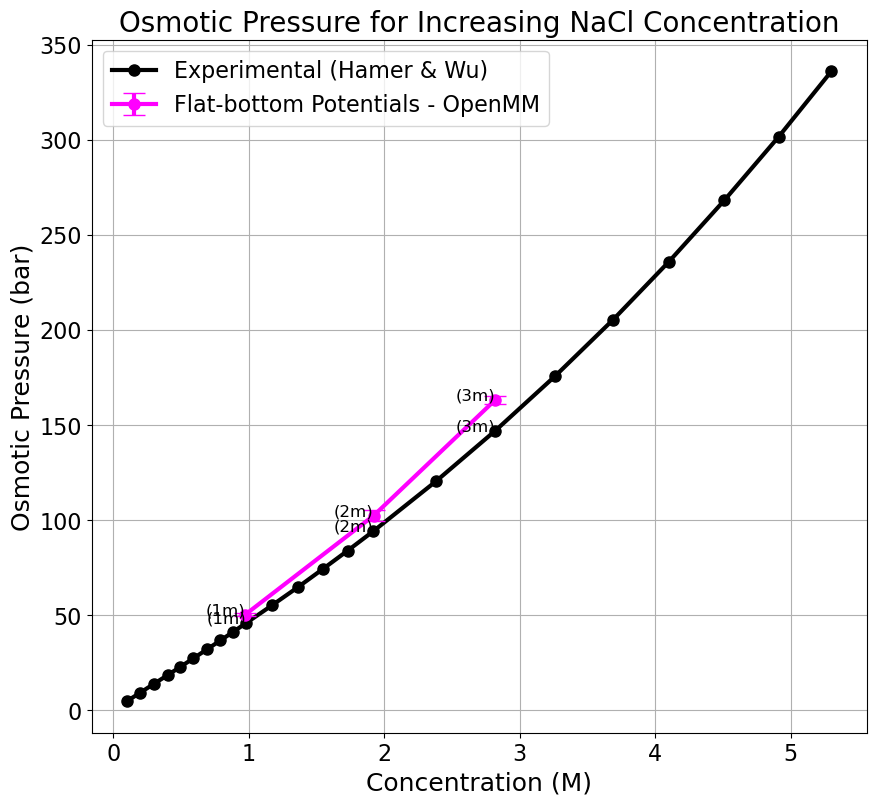

In [72]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))

# Experimental data
plt.plot(exp_concs_values, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(concs_values, fbp_results['OP_Values'], yerr=fbp_results['OP_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenMM', linewidth=3, markersize=8)

# Add labels to the points
for i in range(len(concs_values)):
    x_val = concs_values[i]  # Scalar value
    y_val = fbp_results['OP_Values'][i]
    plt.text(x_val, y_val, f"({molalities[i]})", fontsize=12, ha='right')

# Add labels to the specific experimental points
special_labels = {0.98: '1m', 1.92: '2m', 2.82: '3m'}
for i in range(len(exp_concs_values)):
    x_val = exp_concs_values[i]  # Scalar value
    y_val = yexpOP[i]
    if x_val in special_labels:  # Check if x_val is in the special_labels dictionary
        plt.text(x_val, y_val, f"({special_labels[x_val]})", fontsize=12, ha='right')

plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)", fontsize=MEDIUM_SIZE)
plt.title('Osmotic Pressure for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend()
plt.grid()
plt.savefig('ops.png')
plt.show()

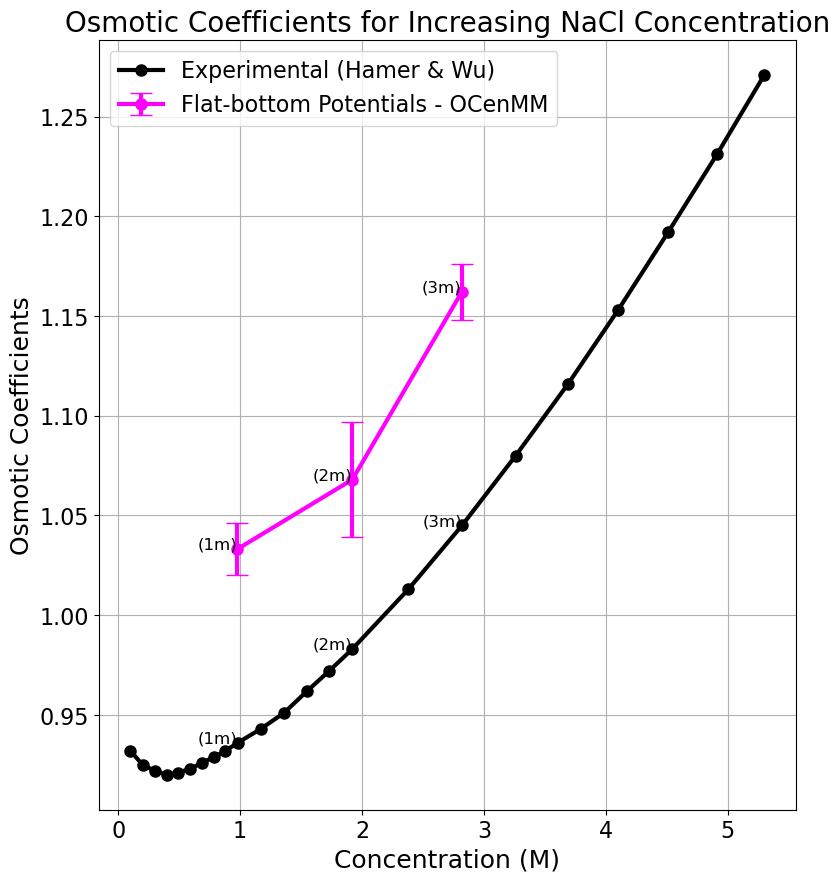

In [71]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))

# Experimental data
plt.plot(exp_concs_values, yexpOC, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(concs_values, fbp_results['OC_Values'], yerr=fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OCenMM', linewidth=3, markersize=8)

# Add labels to the calculated points
for i in range(len(concs_values)):
    x_val = concs_values[i]  # Scalar value
    y_val = fbp_results['OC_Values'][i]
    plt.text(x_val, y_val, f"({molalities[i]})", fontsize=12, ha='right')

# Add labels to the specific experimental points
special_labels = {0.98: '1m', 1.92: '2m', 2.82: '3m'}
for i in range(len(exp_concs_values)):
    x_val = exp_concs_values[i]  # Scalar value
    y_val = yexpOC[i]
    if x_val in special_labels:  # Check if x_val is in the special_labels dictionary
        plt.text(x_val, y_val, f"({special_labels[x_val]})", fontsize=12, ha='right')

plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
plt.title('Osmotic Coefficients for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.grid()
plt.savefig('ocs.png')
plt.show()